In [3]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertConfig
from torch.optim import AdamW
from peft import LoraConfig, get_peft_model, TaskType
from preprocessing import lanczosinterp2D, make_delayed
from ridge_utils.ridge import bootstrap_ridge, zs
import matplotlib.pyplot as plt
import psutil
import gc

# -------------------------------
# Configuration
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

raw_text_path = "/ocean/projects/mth240012p/shared/data/raw_text.pkl"
embedding_save_dir = "bert_embeddings_lora"
downsampled_save_dir = "bert_embeddings_lora_delayed"
os.makedirs(embedding_save_dir, exist_ok=True)
os.makedirs(downsampled_save_dir, exist_ok=True)
subject_dirs = {
    "subject2": "/ocean/projects/mth240012p/shared/data/subject2",
    "subject3": "/ocean/projects/mth240012p/shared/data/subject3"
}
delays = [1, 2, 3, 4]
trim_front, trim_back = 5, 10
alphas = np.logspace(0, 3, 5)
nboots, chunklen, nchunks = 15, 10, 10

# -------------------------------
# Load raw text
# -------------------------------
with open(raw_text_path, "rb") as f:
    raw_text = pickle.load(f)
story_names = list(raw_text.keys())

# -------------------------------
# Load LoRA fine-tuned BERT
# -------------------------------
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
base_model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION
)
model = get_peft_model(base_model, lora_config).to(device)

# -------------------------------
# Extract and Save Embeddings
# -------------------------------
def get_lora_embeddings(tokens):
    tokens = [t for t in tokens if t.strip()]
    inputs = tokenizer(tokens, return_tensors="pt", padding=True, truncation=True, is_split_into_words=True)
    with torch.no_grad():
        outputs = model(**inputs.to(device))
        hidden_states = outputs.last_hidden_state
    return hidden_states.mean(dim=1).cpu().numpy()

for story_name, ds in tqdm(raw_text.items(), desc="Extracting embeddings"):
    try:
        emb = get_lora_embeddings(ds.data)
        np.save(os.path.join(embedding_save_dir, f"{story_name}.npy"), emb)
    except Exception as e:
        print(f"Failed {story_name}: {e}")

# -------------------------------
# Downsample and Delay
# -------------------------------
vectors = {s: np.load(f"{embedding_save_dir}/{s}.npy") for s in story_names}

def downsample_embeddings(story_list, vectors, wordseqs):
    downsampled = {}
    for story in story_list:
        vec = vectors[story]
        if len(wordseqs[story].data_times) != vec.shape[0]:
            story_duration = wordseqs[story].tr_times[-1]
            wordseqs[story].data_times = np.linspace(0, story_duration, vec.shape[0])
        downsampled[story] = lanczosinterp2D(
            vec, wordseqs[story].data_times, wordseqs[story].tr_times, window=3
        )
    return downsampled

downsampled = downsample_embeddings(story_names, vectors, raw_text)

def trim_and_delay(data_dict):
    return {k: make_delayed(v[trim_front:-trim_back], delays) for k, v in data_dict.items()}

delayed_embeddings = trim_and_delay(downsampled)

for story, embedding in delayed_embeddings.items():
    np.save(os.path.join(downsampled_save_dir, f"{story}.npy"), embedding)


Using device: cuda


/var/tmp/ipykernel_52311/1489217121.py:41: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  raw_text = pickle.load(f)
Extracting embeddings: 100%|██████████| 109/109 [00:05<00:00, 18.90it/s]


In [30]:
# -------------------------------
# Fine Tuning
# -------------------------------
# This block fine-tunes the LoRA adapters with a small regression head

class LoRAVoxelModel(nn.Module):
    def __init__(self, peft_model, input_dim, n_voxels):
        super().__init__()
        self.peft = peft_model
        self.head = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, n_voxels)
        )

    def forward(self, x):
        # x: [T, input_dim]
        return self.head(x)  # [T, n_voxels]

for subject, subj_path in subject_dirs.items():
    print(f"Fine-tuning LoRA adapters on {subject}…")

    split = int(len(story_names) * 0.8)
    train_keys = story_names[:split]

    X_list, Y_list = [], []
    for s in train_keys:
        y_file = os.path.join(subj_path, f"{s}.npy")
        if not os.path.exists(y_file): continue
        X = delayed_embeddings[s]  # [T, input_dim]
        Y = np.load(y_file, mmap_mode="r")  # [T, n_voxels]
        if X.shape[0] != Y.shape[0]: continue
        X_list.append(X.astype(np.float32))
        Y_list.append(Y.astype(np.float32))

    if not X_list:
        print(f"No data for {subject}, skipping.")
        continue

    X_train = np.concatenate(X_list, axis=0)  # [N, input_dim]
    Y_train = np.concatenate(Y_list, axis=0)  # [N, n_voxels]

    # Remove any rows with NaNs or Infs
    mask = np.isfinite(X_train).all(axis=1) & np.isfinite(Y_train).all(axis=1)
    X_train = X_train[mask]
    Y_train = Y_train[mask]

    # Normalize input features only
    X_mean, X_std = X_train.mean(axis=0), X_train.std(axis=0) + 1e-8
    X_train = (X_train - X_mean) / X_std
    # keep Y_train in original scale to avoid near-zero std issues
    X_mean, X_std = X_train.mean(axis=0), X_train.std(axis=0) + 1e-8
    Y_mean, Y_std = Y_train.mean(axis=0), Y_train.std(axis=0) + 1e-8
    X_train = (X_train - X_mean) / X_std
    Y_train = (Y_train - Y_mean) / Y_std

    class FMRIDataset(Dataset):
        def __init__(self, X, Y):
            self.X = torch.from_numpy(X)
            self.Y = torch.from_numpy(Y)
        def __len__(self):
            return len(self.X)
        def __getitem__(self, idx):
            return self.X[idx], self.Y[idx]

    ds = FMRIDataset(X_train, Y_train)
    loader = DataLoader(ds, batch_size=4, shuffle=True)

    input_dim  = X_train.shape[1]
    n_voxels   = Y_train.shape[1]

    finetune_model = LoRAVoxelModel(model, input_dim, n_voxels).to(device)
    optimizer = AdamW(
        filter(lambda p: p.requires_grad, finetune_model.parameters()),
        lr=1e-5  # lower LR to stabilize training
    )
    criterion = nn.MSELoss()

    finetune_model.train()
    for epoch in range(5):
        running_loss = 0.0
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)  # [batch, input_dim]
            y_batch = y_batch.to(device)  # [batch, n_voxels]

            preds = finetune_model(x_batch)             # [batch, n_voxels]
            loss  = criterion(preds, y_batch)           # MSE

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(finetune_model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()

        print(f"  Epoch {epoch+1}/5 — avg MSE: {running_loss/len(loader):.4f}")

    # switch back to eval so that subsequent feature extraction uses fine-tuned adapters
    model.eval()
    torch.cuda.empty_cache()
        # Save LoRA adapter so we can reload later without re-running finetuning
    adapter_dir = os.path.join("lora_adapters", subject)
    os.makedirs(adapter_dir, exist_ok=True)
    # model is the PEFT-wrapped BERT; save its adapter weights
    model.save_pretrained(adapter_dir)
    print(f"Saved LoRA adapter for {subject} to {adapter_dir}")

    gc.collect()

Fine-tuning LoRA adapters on subject2…
  Epoch 1/5 — avg MSE: 1.0067
  Epoch 2/5 — avg MSE: 1.0006
  Epoch 3/5 — avg MSE: 1.0001
  Epoch 4/5 — avg MSE: 0.9996
  Epoch 5/5 — avg MSE: 0.9993
Saved LoRA adapter for subject2 to lora_adapters/subject2
Fine-tuning LoRA adapters on subject3…
  Epoch 1/5 — avg MSE: 1.0065
  Epoch 2/5 — avg MSE: 1.0004
  Epoch 3/5 — avg MSE: 0.9998
  Epoch 4/5 — avg MSE: 0.9992
  Epoch 5/5 — avg MSE: 0.9988
Saved LoRA adapter for subject3 to lora_adapters/subject3


Reloading adapter and evaluating subject2...


Extracting FT embeddings for subject2: 100%|██████████| 109/109 [00:04<00:00, 21.85it/s]


Evaluating ridge regression for subject2...
Running bootstrap_ridge... (RAM: 2.2%)


/jet/home/xliang8/.conda/envs/env_214/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


Results for subject2 (FT LoRA-BERT):
Mean CC:   0.0172
Median CC: 0.0144
Top 1% CC: 0.0898
Top 5% CC: 0.0572


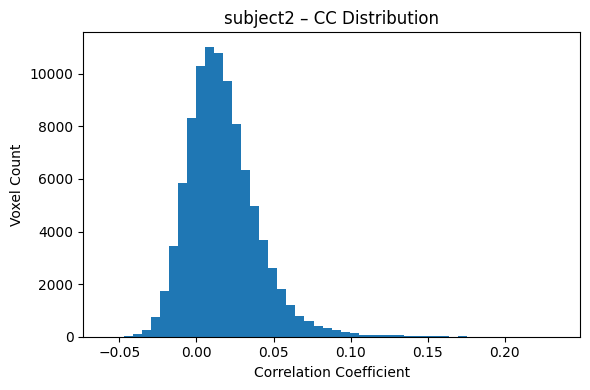

Reloading adapter and evaluating subject3...


Extracting FT embeddings for subject3: 100%|██████████| 109/109 [00:04<00:00, 21.88it/s]


Evaluating ridge regression for subject3...
Running bootstrap_ridge... (RAM: 2.4%)
Results for subject3 (FT LoRA-BERT):
Mean CC:   0.0214
Median CC: 0.0183
Top 1% CC: 0.1140
Top 5% CC: 0.0658


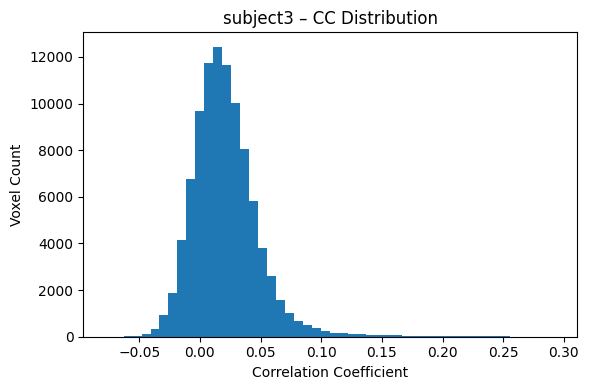

In [5]:
# -------------------------------
# Evaluate per subject using saved LoRA adapters
# -------------------------------
for subject, subj_path in subject_dirs.items():
    print(f"Reloading adapter and evaluating {subject}...")

    # Reload base BERT and load the fine-tuned adapter for this subject
    base = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
    peft_model = get_peft_model(base, lora_config).to(device)
    adapter_dir = os.path.join("lora_adapters", subject)
    peft_model.load_adapter(adapter_dir, adapter_name=subject)
    peft_model.eval()

    # Local embedding extractor using this subject's adapter
    def get_ft_embeddings(tokens):
        tokens = [t for t in tokens if t.strip()]
        inputs = tokenizer(tokens, return_tensors="pt", padding=True, truncation=True, is_split_into_words=True)
        with torch.no_grad():
            outputs = peft_model(**inputs.to(device))
            return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

    # Extract fine-tuned embeddings for all stories
    vectors_ft = {}
    for story_name, ds in tqdm(raw_text.items(), desc=f"Extracting FT embeddings for {subject}"):
        try:
            emb = get_ft_embeddings(ds.data)
            vectors_ft[story_name] = emb
        except Exception as e:
            print(f"Failed FT {story_name} for {subject}: {e}")

    # Downsample & delay for this subject
    downsampled_ft = downsample_embeddings(story_names, vectors_ft, raw_text)
    delayed_ft = {k: make_delayed(v[trim_front:-trim_back], delays) for k, v in downsampled_ft.items()}

    # -------------------------------
    # Ridge Regression Evaluation
    # -------------------------------
    print(f"Evaluating ridge regression for {subject}...")
    train_keys = story_names[:int(len(story_names) * 0.8)]
    test_keys  = story_names[int(len(story_names) * 0.8):]

    X_train, Y_train, X_test, Y_test = [], [], [], []
    for s in train_keys:
        y_file = os.path.join(subj_path, f"{s}.npy")
        if os.path.exists(y_file) and s in delayed_ft:
            X, Y = delayed_ft[s], np.load(y_file)
            if X.shape[0] == Y.shape[0]:
                X_train.append(X);
                Y_train.append(Y)
    for s in test_keys:
        y_file = os.path.join(subj_path, f"{s}.npy")
        if os.path.exists(y_file) and s in delayed_ft:
            X, Y = delayed_ft[s], np.load(y_file)
            if X.shape[0] == Y.shape[0]:
                X_test.append(X);
                Y_test.append(Y)

    X_train = np.concatenate(X_train, axis=0).astype(np.float32)
    Y_train = np.concatenate(Y_train, axis=0).astype(np.float32)
    X_test  = np.concatenate(X_test,  axis=0).astype(np.float32)
    Y_test  = np.concatenate(Y_test,  axis=0).astype(np.float32)

    # z-score normalize
    X_mean, X_std = X_train.mean(0), X_train.std(0) + 1e-8
    Y_mean, Y_std = Y_train.mean(0), Y_train.std(0) + 1e-8
    X_train_z = (X_train - X_mean) / X_std
    Y_train_z = (Y_train - Y_mean) / Y_std
    X_test_z  = (X_test  - X_mean) / X_std
    Y_test_z  = (Y_test  - Y_mean) / Y_std

    # clean up to save RAM
    del X_train, Y_train, X_test, Y_test
    gc.collect()

    # bootstrap ridge
    print(f"Running bootstrap_ridge... (RAM: {psutil.virtual_memory().percent:.1f}%)")
    wt, corrs, valphas, *_ = bootstrap_ridge(
        X_train_z, Y_train_z, X_test_z, Y_test_z,
        alphas=alphas, nboots=nboots,
        chunklen=chunklen, nchunks=nchunks,
        single_alpha=False, use_corr=True
    )

    # -------------------------------
    # Save per-story data for Part 2
    # -------------------------------
    story_to_analyze = "sloth"

    # Extract X and Y for the target story
    X_story = delayed_ft[story_to_analyze]
    Y_story = np.load(os.path.join(subj_path, f"{story_to_analyze}.npy"))

    # Normalize using training stats
    X_story_z = (X_story - X_mean) / X_std
    Y_story_z = (Y_story - Y_mean) / Y_std

    # Save files for Part 2 interpretation
    np.save(f"wt_{subject}_{story_to_analyze}.npy", wt)
    np.save(f"X_story_z_{subject}_{story_to_analyze}.npy", X_story_z)
    np.save(f"Y_story_z_{subject}_{story_to_analyze}.npy", Y_story_z)
    np.save(f"valphas_{subject}_{story_to_analyze}.npy", valphas)

    # report
    print(f"Results for {subject} (FT LoRA-BERT):")
    print(f"Mean CC:   {np.mean(corrs):.4f}")
    print(f"Median CC: {np.median(corrs):.4f}")
    print(f"Top 1% CC: {np.percentile(corrs, 99):.4f}")
    print(f"Top 5% CC: {np.percentile(corrs, 95):.4f}")

    # plot
    plt.figure(figsize=(6,4))
    plt.hist(corrs, bins=50)
    plt.title(f"{subject} – CC Distribution")
    plt.xlabel("Correlation Coefficient")
    plt.ylabel("Voxel Count")
    plt.tight_layout()
    plt.show()


    # cleanup
    del X_train_z, Y_train_z, X_test_z, Y_test_z, wt, corrs, valphas
    torch.cuda.empty_cache()
    gc.collect()


In [6]:
import numpy as np

# Choose subject and story
subject = "subject3"         # or "subject3"
story_to_analyze = "sloth"   # your test story

# Load saved outputs
wt = np.load(f"wt_{subject}_{story_to_analyze}.npy")
X_story_z = np.load(f"X_story_z_{subject}_{story_to_analyze}.npy")
Y_story_z = np.load(f"Y_story_z_{subject}_{story_to_analyze}.npy")

# Predict voxel responses
Y_pred_story = X_story_z @ wt  # shape: (T, V)

# Compute correlation coefficients per voxel
corrs_story = np.array([
    np.corrcoef(Y_story_z[:, i], Y_pred_story[:, i])[0, 1]
    for i in range(Y_story_z.shape[1])
])

# Select top 5 voxels
top_voxel_indices = np.argsort(corrs_story)[-5:][::-1]

# Print results
print(f"Top 5 voxels with highest CC for story '{story_to_analyze}' in {subject}:")
for idx in top_voxel_indices:
    print(f"  Voxel {idx}: CC = {corrs_story[idx]:.4f}")

# Save for SHAP/LIME
np.save(f"top_voxels_{subject}_{story_to_analyze}.npy", top_voxel_indices)
np.save(f"corrs_{subject}_{story_to_analyze}.npy", corrs_story)


Top 5 voxels with highest CC for story 'sloth' in subject3:
  Voxel 36576: CC = 0.3230
  Voxel 16126: CC = 0.3014
  Voxel 27542: CC = 0.2939
  Voxel 69935: CC = 0.2915
  Voxel 27505: CC = 0.2905


In [7]:
import numpy as np
import shap
from collections import defaultdict

# Setup
subject = "subject3"
story_to_analyze = "sloth"
delays = [0, 1, 2, 3, 4]
D = 768
timepoints = [10, 50, 100, 150, 200]

# Load data
X_story_z = np.load(f"X_story_z_{subject}_{story_to_analyze}.npy")
wt = np.load(f"wt_{subject}_{story_to_analyze}.npy")
top_voxels = np.load(f"top_voxels_{subject}_{story_to_analyze}.npy")
tokens = raw_text[story_to_analyze].data

# Loop over voxels
for voxel_idx in top_voxels:
    print(f"\n=== Aggregated SHAP for Voxel {voxel_idx} ===")
    wt_voxel = wt[:, voxel_idx]
    explainer = shap.KernelExplainer(lambda X: X @ wt_voxel, X_story_z[:50])

    # Accumulate SHAP values across timepoints
    token_shap_scores = defaultdict(float)

    for t in timepoints:
        shap_vals = explainer.shap_values(X_story_z[t:t+1])[0]

        for dim, val in enumerate(shap_vals):
            delay_idx = dim // D
            token_dim = dim % D
            token_pos = t - delays[delay_idx]

            if 0 <= token_pos < len(tokens):
                token_shap_scores[tokens[token_pos]] += abs(val)

    # Sort and display top tokens
    sorted_tokens = sorted(token_shap_scores.items(), key=lambda x: -x[1])[:5]
    for token, score in sorted_tokens:
        print(f"  Token: '{token}' — Aggregated SHAP = {score:.4f}")





=== Aggregated SHAP for Voxel 36576 ===


100%|██████████| 1/1 [00:06<00:00,  6.20s/it]


  Token: 'this' — Aggregated SHAP = 0.0183
  Token: 'all' — Aggregated SHAP = 0.0143
  Token: 'we' — Aggregated SHAP = 0.0136
  Token: 'moth' — Aggregated SHAP = 0.0130
  Token: 'to' — Aggregated SHAP = 0.0123

=== Aggregated SHAP for Voxel 16126 ===


100%|██████████| 1/1 [00:06<00:00,  6.21s/it]


  Token: 'all' — Aggregated SHAP = 0.0192
  Token: 'the' — Aggregated SHAP = 0.0133
  Token: 'and' — Aggregated SHAP = 0.0132
  Token: 'when' — Aggregated SHAP = 0.0128
  Token: 'live' — Aggregated SHAP = 0.0124

=== Aggregated SHAP for Voxel 27542 ===


100%|██████████| 1/1 [00:06<00:00,  6.17s/it]


  Token: 'all' — Aggregated SHAP = 0.0253
  Token: 'we' — Aggregated SHAP = 0.0242
  Token: 'one' — Aggregated SHAP = 0.0220
  Token: 'to' — Aggregated SHAP = 0.0187
  Token: 'under' — Aggregated SHAP = 0.0172

=== Aggregated SHAP for Voxel 69935 ===


100%|██████████| 1/1 [00:06<00:00,  6.19s/it]


  Token: 'we' — Aggregated SHAP = 0.0306
  Token: 'do' — Aggregated SHAP = 0.0299
  Token: 'this' — Aggregated SHAP = 0.0261
  Token: 'all' — Aggregated SHAP = 0.0259
  Token: 'the' — Aggregated SHAP = 0.0205

=== Aggregated SHAP for Voxel 27505 ===


100%|██████████| 1/1 [00:06<00:00,  6.18s/it]

  Token: 'do' — Aggregated SHAP = 0.0126
  Token: 'we' — Aggregated SHAP = 0.0111
  Token: 'under' — Aggregated SHAP = 0.0102
  Token: 'all' — Aggregated SHAP = 0.0094
  Token: 'one' — Aggregated SHAP = 0.0094


In [8]:
from lime import lime_tabular
from collections import defaultdict
import numpy as np

# Setup
subject = "subject3"
story_to_analyze = "sloth"
delays = [0, 1, 2, 3, 4]  # match your training config
D = 768  # BERT hidden size
timepoints = [10, 50, 100, 150, 200]

# Load data
X_story_z = np.load(f"X_story_z_{subject}_{story_to_analyze}.npy")
wt = np.load(f"wt_{subject}_{story_to_analyze}.npy")
top_voxels = np.load(f"top_voxels_{subject}_{story_to_analyze}.npy")
tokens = raw_text[story_to_analyze].data  # original token list

# Loop over top voxels
for voxel_idx in top_voxels:
    print(f"\n=== Aggregated LIME for Voxel {voxel_idx} ===")
    wt_voxel = wt[:, voxel_idx]

    def predict_fn(X):
        return X @ wt_voxel

    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_story_z,
        mode="regression",
        feature_names=[f"dim_{i}" for i in range(X_story_z.shape[1])],
        verbose=False
    )

    token_lime_scores = defaultdict(float)

    for t in timepoints:
        exp = explainer.explain_instance(X_story_z[t], predict_fn, num_features=10)

        for dim_name, val in exp.as_list():
            try:
                # Robust extraction of dim index
                dim = int(dim_name.split("_")[1].split()[0])
                delay_idx = dim // D
                token_dim = dim % D
                token_pos = t - delays[delay_idx]

                if 0 <= token_pos < len(tokens):
                    token = tokens[token_pos]
                    token_lime_scores[token] += abs(val)
            except Exception as e:
                print(f"  Skipped feature '{dim_name}': {e}")

    # Show top 5 tokens for this voxel
    sorted_tokens = sorted(token_lime_scores.items(), key=lambda x: -x[1])[:5]
    for token, score in sorted_tokens:
        print(f"  Token: '{token}' — Aggregated LIME = {score:.4f}")



=== Aggregated LIME for Voxel 36576 ===
  Token: 'this' — Aggregated LIME = 0.0299
  Token: 'we' — Aggregated LIME = 0.0252
  Token: 'and' — Aggregated LIME = 0.0202
  Token: 'all' — Aggregated LIME = 0.0188
  Token: 'age' — Aggregated LIME = 0.0163

=== Aggregated LIME for Voxel 16126 ===
  Token: 'age' — Aggregated LIME = 0.0390
  Token: 'this' — Aggregated LIME = 0.0358
  Token: 'and' — Aggregated LIME = 0.0347
  Token: 'when' — Aggregated LIME = 0.0337
  Token: 'we' — Aggregated LIME = 0.0325

=== Aggregated LIME for Voxel 27542 ===
  Token: 'under' — Aggregated LIME = 0.0235
  Token: 'one' — Aggregated LIME = 0.0212
  Token: 'to' — Aggregated LIME = 0.0207
  Token: 'started' — Aggregated LIME = 0.0205
  Token: 'all' — Aggregated LIME = 0.0202

=== Aggregated LIME for Voxel 69935 ===
  Token: 'all' — Aggregated LIME = 0.0166
  Token: 'and' — Aggregated LIME = 0.0153
  Token: 'when' — Aggregated LIME = 0.0146
  Token: 'moth' — Aggregated LIME = 0.0137
  Token: 'time' — Aggregated L

In [9]:
shap_top_words = {}
lime_top_words = {}

for voxel_idx in top_voxels:
    print(f"\nRunning SHAP and LIME for voxel {voxel_idx}...")
    wt_voxel = wt[:, voxel_idx]

    # --- SHAP ---
    explainer_shap = shap.KernelExplainer(lambda X: X @ wt_voxel, X_story_z[:50])
    token_shap_scores = defaultdict(float)
    for t in timepoints:
        shap_vals = explainer_shap.shap_values(X_story_z[t:t+1])[0]
        for dim, val in enumerate(shap_vals):
            delay_idx = dim // D
            token_pos = t - delays[delay_idx]
            if 0 <= token_pos < len(tokens):
                token_shap_scores[tokens[token_pos]] += abs(val)
    shap_top_words[voxel_idx] = sorted(token_shap_scores.items(), key=lambda x: -x[1])[:5]

    # --- LIME ---
    explainer_lime = lime_tabular.LimeTabularExplainer(
        training_data=X_story_z,
        mode="regression",
        feature_names=[f"dim_{i}" for i in range(X_story_z.shape[1])]
    )
    token_lime_scores = defaultdict(float)
    for t in timepoints:
        exp = explainer_lime.explain_instance(X_story_z[t], lambda X: X @ wt_voxel, num_features=10)
        for dim_name, val in exp.as_list():
            try:
                dim = int(dim_name.split("_")[1].split()[0])
                delay_idx = dim // D
                token_pos = t - delays[delay_idx]
                if 0 <= token_pos < len(tokens):
                    token_lime_scores[tokens[token_pos]] += abs(val)
            except:
                continue
    lime_top_words[voxel_idx] = sorted(token_lime_scores.items(), key=lambda x: -x[1])[:5]




Running SHAP and LIME for voxel 36576...


100%|██████████| 1/1 [00:06<00:00,  6.21s/it]



Running SHAP and LIME for voxel 16126...


100%|██████████| 1/1 [00:06<00:00,  6.43s/it]



Running SHAP and LIME for voxel 27542...


100%|██████████| 1/1 [00:06<00:00,  6.25s/it]



Running SHAP and LIME for voxel 69935...


100%|██████████| 1/1 [00:06<00:00,  6.29s/it]



Running SHAP and LIME for voxel 27505...


100%|██████████| 1/1 [00:06<00:00,  6.25s/it]


In [18]:
import pandas as pd

# Create a list of rows to feed into the DataFrame
rows = []

for voxel in shap_top_words:
    row = {"Voxel": voxel}
    for i in range(5):
        shap_word = shap_top_words[voxel][i][0] if i < len(shap_top_words[voxel]) else "-"
        lime_word = lime_top_words[voxel][i][0] if i < len(lime_top_words[voxel]) else "-"
        row[f"SHAP_{i+1}"] = shap_word
        row[f"LIME_{i+1}"] = lime_word
    rows.append(row)

# Convert to DataFrame
df_comparison = pd.DataFrame(rows)
df_comparison = df_comparison.sort_values("Voxel").reset_index(drop=True)

# Display
from IPython.display import display
display(df_comparison)


,Voxel,SHAP_1,LIME_1,SHAP_2,LIME_2,SHAP_3,LIME_3,SHAP_4,LIME_4,SHAP_5,LIME_5
0,16126,this,we,live,age,all,this,when,when,and,and
1,27505,all,we,live,started,this,the,to,and,age,time
2,27542,under,all,all,one,we,we,moth,the,it,live
3,36576,all,this,this,we,moth,it,we,all,age,do
4,69935,this,all,we,under,and,this,started,when,the,and


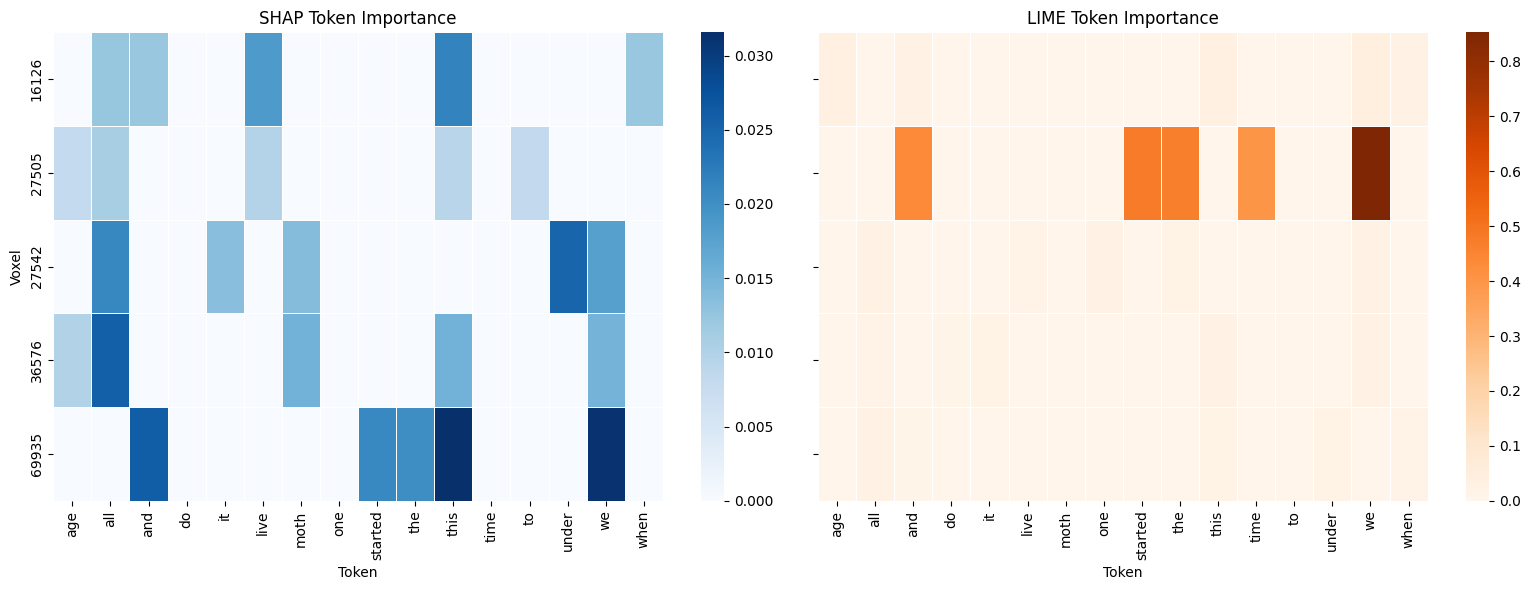

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Step 1: Collect all unique tokens
all_tokens = set()
for v in shap_top_words:
    all_tokens.update(w for w, _ in shap_top_words[v])
    all_tokens.update(w for w, _ in lime_top_words[v])
all_tokens = sorted(all_tokens)

# Step 2: Create DataFrames (rows = voxels, columns = tokens)
shap_matrix = pd.DataFrame(0.0, index=sorted(shap_top_words.keys()), columns=all_tokens)
lime_matrix = pd.DataFrame(0.0, index=sorted(lime_top_words.keys()), columns=all_tokens)

# Fill SHAP
for voxel, word_scores in shap_top_words.items():
    for word, score in word_scores:
        shap_matrix.loc[voxel, word] = score

# Fill LIME
for voxel, word_scores in lime_top_words.items():
    for word, score in word_scores:
        lime_matrix.loc[voxel, word] = score

# Step 3: Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.heatmap(shap_matrix, ax=axes[0], cmap="Blues", cbar=True, linewidths=0.5, annot=False)
axes[0].set_title("SHAP Token Importance")
axes[0].set_xlabel("Token")
axes[0].set_ylabel("Voxel")

sns.heatmap(lime_matrix, ax=axes[1], cmap="Oranges", cbar=True, linewidths=0.5, annot=False)
axes[1].set_title("LIME Token Importance")
axes[1].set_xlabel("Token")
axes[1].set_ylabel("")


plt.tight_layout()
plt.savefig("shap_lime_heatmap_sloth.png", dpi=300)  
plt.show()



In [24]:
# -------------------------------
# Save per-story data for Part 2
# -------------------------------
story_to_analyze = "quietfire"
subject = "subject3"

# Extract X and Y for the target story
X_story = delayed_ft[story_to_analyze]
Y_story = np.load(os.path.join(subj_path, f"{story_to_analyze}.npy"))

# Normalize using training stats (from training set)
X_story_z = (X_story - X_mean) / X_std
Y_story_z = (Y_story - Y_mean) / Y_std

# Save files for Part 2 SHAP/LIME interpretation
np.save(f"wt_{subject}_{story_to_analyze}.npy", wt)
np.save(f"X_story_z_{subject}_{story_to_analyze}.npy", X_story_z)
np.save(f"Y_story_z_{subject}_{story_to_analyze}.npy", Y_story_z)

print(f"Saved standardized data and weights for story: {story_to_analyze}")


Saved standardized data and weights for story: quietfire


In [25]:
import numpy as np

# Setup
subject = "subject3"
story_to_analyze = "quietfire"

# Load saved data
X_story_z = np.load(f"X_story_z_{subject}_{story_to_analyze}.npy")
Y_story_z = np.load(f"Y_story_z_{subject}_{story_to_analyze}.npy")
wt = np.load(f"wt_{subject}_{story_to_analyze}.npy")

# Predict
Y_pred_story = X_story_z @ wt

# Correlation per voxel
corrs_story = np.array([
    np.corrcoef(Y_story_z[:, i], Y_pred_story[:, i])[0, 1]
    for i in range(Y_story_z.shape[1])
])

# Select top 5 voxels
top_voxel_indices = np.argsort(corrs_story)[-5:][::-1]
np.save(f"top_voxels_{subject}_{story_to_analyze}.npy", top_voxel_indices)

# Print summary
print(f"Top 5 voxels for story '{story_to_analyze}':")
for idx in top_voxel_indices:
    print(f"  Voxel {idx}: CC = {corrs_story[idx]:.4f}")


Top 5 voxels for story 'quietfire':
  Voxel 6828: CC = 0.6579
  Voxel 6813: CC = 0.6442
  Voxel 6851: CC = 0.6248
  Voxel 6829: CC = 0.6028
  Voxel 6850: CC = 0.4475


In [26]:
import shap
from lime import lime_tabular
from collections import defaultdict
import numpy as np

# Configuration
subject = "subject3"
story_to_analyze = "quietfire"
delays = [0, 1, 2, 3, 4]
D = 768
timepoints = [10, 50, 100, 150, 200]

# Load saved data
X_story_z = np.load(f"X_story_z_{subject}_{story_to_analyze}.npy")
Y_story_z = np.load(f"Y_story_z_{subject}_{story_to_analyze}.npy")
wt = np.load(f"wt_{subject}_{story_to_analyze}.npy")
top_voxels = np.load(f"top_voxels_{subject}_{story_to_analyze}.npy")
tokens = raw_text[story_to_analyze].data

# Store aggregated importance
shap_top_words_qf = {}
lime_top_words_qf = {}

# Loop through each voxel
for voxel_idx in top_voxels:
    print(f"\n=== Aggregating SHAP & LIME for voxel {voxel_idx} ===")
    wt_voxel = wt[:, voxel_idx]
    predict_fn = lambda X: X @ wt_voxel

    # SHAP aggregation
    shap_explainer = shap.KernelExplainer(predict_fn, X_story_z[:50])
    token_shap_scores = defaultdict(float)
    for t in timepoints:
        shap_vals = shap_explainer.shap_values(X_story_z[t:t+1])[0]
        for dim, val in enumerate(shap_vals):
            delay_idx = dim // D
            token_pos = t - delays[delay_idx]
            if 0 <= token_pos < len(tokens):
                token_shap_scores[tokens[token_pos]] += abs(val)
    shap_top_words_qf[voxel_idx] = sorted(token_shap_scores.items(), key=lambda x: -x[1])[:5]

    # LIME aggregation
    lime_explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_story_z,
        mode="regression",
        feature_names=[f"dim_{i}" for i in range(X_story_z.shape[1])],
        verbose=False
    )
    token_lime_scores = defaultdict(float)
    for t in timepoints:
        exp = lime_explainer.explain_instance(X_story_z[t], predict_fn, num_features=10)
        for dim_name, val in exp.as_list():
            try:
                dim = int(dim_name.split("_")[1].split()[0])
                delay_idx = dim // D
                token_pos = t - delays[delay_idx]
                if 0 <= token_pos < len(tokens):
                    token = tokens[token_pos]
                    token_lime_scores[token] += abs(val)
            except:
                continue
    lime_top_words_qf[voxel_idx] = sorted(token_lime_scores.items(), key=lambda x: -x[1])[:5]



=== Aggregating SHAP & LIME for voxel 6828 ===


100%|██████████| 1/1 [00:06<00:00,  6.25s/it]



=== Aggregating SHAP & LIME for voxel 6813 ===


100%|██████████| 1/1 [00:06<00:00,  6.39s/it]



=== Aggregating SHAP & LIME for voxel 6851 ===


100%|██████████| 1/1 [00:06<00:00,  6.29s/it]



=== Aggregating SHAP & LIME for voxel 6829 ===


100%|██████████| 1/1 [00:06<00:00,  6.29s/it]



=== Aggregating SHAP & LIME for voxel 6850 ===


100%|██████████| 1/1 [00:06<00:00,  6.33s/it]


In [28]:
import pandas as pd

# Create a list of rows to feed into the DataFrame
rows = []

for voxel in shap_top_words_qf:
    row = {"Voxel": voxel}
    for i in range(5):
        shap_word = shap_top_words_qf[voxel][i][0] if i < len(shap_top_words_qf[voxel]) else "-"
        lime_word = lime_top_words_qf[voxel][i][0] if i < len(lime_top_words_qf[voxel]) else "-"
        row[f"SHAP_{i+1}"] = shap_word
        row[f"LIME_{i+1}"] = lime_word
    rows.append(row)

# Convert to DataFrame
df_comparison = pd.DataFrame(rows)
df_comparison = df_comparison.sort_values("Voxel").reset_index(drop=True)

# Display
from IPython.display import display
display(df_comparison)



,Voxel,SHAP_1,LIME_1,SHAP_2,LIME_2,SHAP_3,LIME_3,SHAP_4,LIME_4,SHAP_5,LIME_5
0,6813,up,over,over,thought,thought,of,of,city,city,up
1,6828,of,thought,up,over,over,of,city,up,thought,city
2,6829,over,of,of,city,city,up,thought,over,a,thought
3,6850,over,thought,thought,up,city,of,of,over,up,city
4,6851,thought,of,city,over,of,up,up,city,over,thought


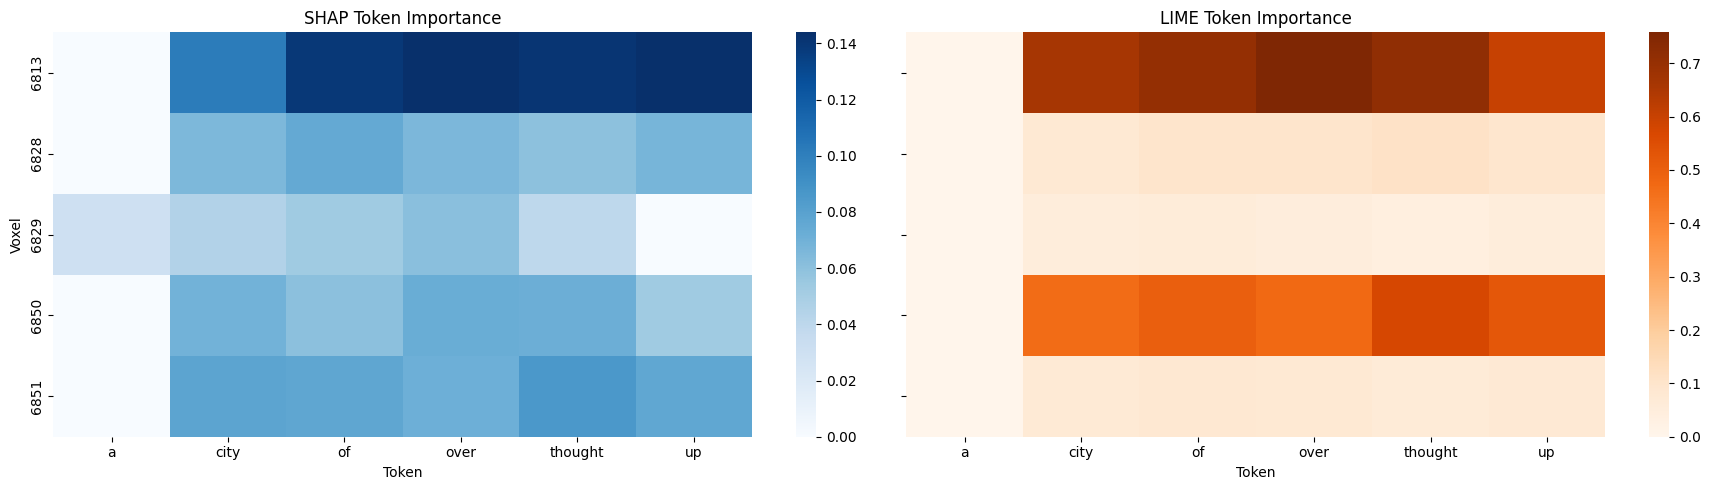

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Step 1: Gather all tokens from SHAP and LIME top-5 across all voxels
all_tokens = sorted(
    list({w for v in shap_top_words_qf for w, _ in shap_top_words_qf[v]} |
         {w for v in lime_top_words_qf for w, _ in lime_top_words_qf[v]})
)

# Step 2: Get list of voxel indices (sorted for consistent heatmap rows)
voxels = sorted(shap_top_words_qf.keys())

# Step 3: Initialize score matrices
shap_matrix = np.zeros((len(voxels), len(all_tokens)))
lime_matrix = np.zeros((len(voxels), len(all_tokens)))

# Step 4: Fill score matrices
for i, voxel in enumerate(voxels):
    shap_dict = dict(shap_top_words_qf[voxel])
    lime_dict = dict(lime_top_words_qf[voxel])
    for j, token in enumerate(all_tokens):
        shap_matrix[i, j] = shap_dict.get(token, 0)
        lime_matrix[i, j] = lime_dict.get(token, 0)

# Step 5: Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)

sns.heatmap(shap_matrix, ax=axes[0], cmap="Blues", xticklabels=all_tokens,
            yticklabels=voxels, cbar=True)
axes[0].set_title("SHAP Token Importance")
axes[0].set_xlabel("Token")
axes[0].set_ylabel("Voxel")

sns.heatmap(lime_matrix, ax=axes[1], cmap="Oranges", xticklabels=all_tokens,
            yticklabels=voxels, cbar=True)
axes[1].set_title("LIME Token Importance")
axes[1].set_xlabel("Token")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig("shap_lime_heatmap_quietfire.png", dpi=300)
plt.show()
